In [47]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
# import pixiedust

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

# Solving ODEs

## Example 1

$\frac{d}{dx}\Psi+(x+\frac{1+3x^2}{1+x+x^3})\Psi=x^3+2x+x^2\frac{1+3x^2}{1+x+x^3}$

With boundary initial condition $\Psi(0)=1$ and domain $x\in[0,1]$

In [48]:
search = lambda A, B: np.array([i for i in A.flatten().tolist() if i not in B.flatten().tolist()])
Xe1_interpolation = np.linspace(0.,1,num=1000)
Xe1_interpolation = Xe1_interpolation.reshape((Xe1_interpolation.shape[0],1))
Xe1 = Xe1_interpolation[::100]
Xe1_interpolation = search(Xe1_interpolation, Xe1)
Xe1_interpolation = Xe1_interpolation.reshape((Xe1_interpolation.shape[0],1))

The trial solution for this case is $\Psi(x)=1 + x N(x)$.
The first function below is the function $A(x)=1$
and the second function is the function $B(x)=x$.

In [49]:
def example1_initial_value(x):
    return 1

In [50]:
def example1_boundary_vanishing(x):
    return x

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [51]:
# def example1_loss(self, X, *kwargs):
#     N = self(X, 0)
#     dN = self(X, 1)
#     loss = (
#      X * dN + N + (X + (1 + 3 * X ** 2)/(1 + X + X ** 3)) * (1 + X * N) 
#       - X ** 3 - 2 * X - X ** 2 *(1 + 3 * X ** 2)/(1 + X + X ** 3)
#     )
#     loss = loss ** 2
#     return loss
def example1_loss(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * (1 + point * N) 
      - point ** 3 - 2 * point - point ** 2 *(1 + 3 * point ** 2)/(1 + point + point ** 3)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [52]:
def example1_loss_function(self, samples, *kwargs):
    loss = 0
    for i in range(samples.shape[0]):
        loss += self.loss_function_single_point(self, samples[i])
    return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [53]:
def example1_bias_change(self, x, label, *kwargs):
    db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
    loss_sqrt = self.loss_function_single_point(self, x).reshape(1,)
    db_N = self.network_derivative_bias(x, 0)
    db_DN = self.network_derivative_bias(x, 1)
    x = x.reshape((1,))
    for m in range(self.hidden_dim):
        db[m] += 2 * loss_sqrt *( x * db_DN[0, 0, m] + db_N[0, 0, m] + (x + (1 + 3 * x ** 2)/(1 + x + x ** 3)) * x * db_N[0, 0, m])
    return db
# def example1_visible_weights_change(self, point, *kwargs):
#   dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
#   loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
#   dV_N = self.network_derivative_visible_weights(point, 0)
#   dV_DN = self.network_derivative_visible_weights(point, 1)
#   for m in range(self.visible_dim):
#     for p in range(self.hidden_dim):
#       dV[m, p] += 2 * loss_sqrt * (
#         point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
#   return dV

In [54]:
def example1_hidden_weights_change(self, x, *kwargs):
    dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
    loss_sqrt = self.loss_function_single_point(self, x).reshape(1,)
    dH_N = self.network_derivative_hidden_weights(x, 0)
    dH_DN = self.network_derivative_hidden_weights(x, 1)
    x = x.reshape((1,))
    for m in range(self.hidden_dim):
        for p in range(self.input_dim):
            dH[m, p] += 2 * loss_sqrt * (
        x * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + (x + (1 + 3 * x ** 2)/(1 + x + x ** 3)) * x * dH_N[0, 0, m, p])
    return dH
# def example1_visible_weights_change(self, point, *kwargs):
#   dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
#   loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
#   dV_N = self.network_derivative_visible_weights(point, 0)
#   dV_DN = self.network_derivative_visible_weights(point, 1)
#   for m in range(self.visible_dim):
#     for p in range(self.hidden_dim):
#       dV[m, p] += 2 * loss_sqrt * (
#         point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
#   return dV

In [55]:
# def example1_visible_weights_change(self, x, *kwargs):
#     dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
#     loss_sqrt = self.loss_function_single_point(self, x).reshape(1,)
#     dV_N = self.network_derivative_visible_weights(x, 0)
#     dV_DN = self.network_derivative_visible_weights(x, 1)
#     x = x.reshape((1,))
#     for m in range(self.visible_dim):
#         for p in range(self.hidden_dim):
#             dV[m, p] += 2 * loss_sqrt * (
#         x * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (x + (1 + 3 * x ** 2)/(1 + x + x ** 3)) * x * dV_N[0, 0, m, p])
#     return dV
def example1_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (
        point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + (point + (1 + 3 * point ** 2)/(1 + point + point ** 3)) * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [58]:
example1_trial_solution = nnde.TrialSolution(loss_function=example1_loss_function,
                                             loss_function_single_point=example1_loss,
                                             bias_change=example1_bias_change,
                                             hidden_weights_change=example1_hidden_weights_change,
                                             visible_weights_change=example1_visible_weights_change,
                                        boundary_condition_value_function=example1_initial_value,
                                        boundary_vanishing_function=example1_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [59]:
example1_trial_solution.train(samples=Xe1, epochs=1000)

Epoch: 1 Loss function: 3.960497241973729
Epoch: 2 Loss function: 1.6783173035766812
Epoch: 3 Loss function: 0.728650190533656
Epoch: 4 Loss function: 0.6453186399320779
Epoch: 5 Loss function: 9.176715165488687
Epoch: 6 Loss function: 16.08467799445462
Epoch: 7 Loss function: 1.7449172545389893
Epoch: 8 Loss function: 4.63837940858117
Epoch: 9 Loss function: 1.8399023109547143
Epoch: 10 Loss function: 1.0063438110726306
Epoch: 11 Loss function: 2.5913135862648113
Epoch: 12 Loss function: 65.94355733728887
Epoch: 13 Loss function: 10.621636824309704
Epoch: 14 Loss function: 1.3490216392546277
Epoch: 15 Loss function: 1.742103440113763
Epoch: 16 Loss function: 0.5312098909879189
Epoch: 17 Loss function: 1.7160962901969907
Epoch: 18 Loss function: 5.132665118526987
Epoch: 19 Loss function: 2.421917535406384
Epoch: 20 Loss function: 133.87485248174886
Epoch: 21 Loss function: 1.3666774536770132
Epoch: 22 Loss function: 0.5282103560415221
Epoch: 23 Loss function: 1.7782354569847338
Epoch: 

Epoch: 196 Loss function: 0.8323029583199532
Epoch: 197 Loss function: 0.5307827615974862
Epoch: 198 Loss function: 1.40123053160382
Epoch: 199 Loss function: 1.2525455083490875
Epoch: 200 Loss function: 0.9481881812226488
Epoch: 201 Loss function: 0.5339174585792036
Epoch: 202 Loss function: 4.069697701932363
Epoch: 203 Loss function: 1.5004026903784187
Epoch: 204 Loss function: 0.7313552146569322
Epoch: 205 Loss function: 0.547204257313221
Epoch: 206 Loss function: 0.5176926888926058
Epoch: 207 Loss function: 0.5894847775610357
Epoch: 208 Loss function: 0.5459811175980187
Epoch: 209 Loss function: 1.9387241045676784
Epoch: 210 Loss function: 1.2584554320872365
Epoch: 211 Loss function: 1.2896657148127713
Epoch: 212 Loss function: 0.5789315612803179
Epoch: 213 Loss function: 0.5198339763000792
Epoch: 214 Loss function: 0.9107344659912829
Epoch: 215 Loss function: 1.7181783763361431
Epoch: 216 Loss function: 0.9380520268569514
Epoch: 217 Loss function: 0.5391597519565863
Epoch: 218 Los

Epoch: 379 Loss function: 0.5499204630432813
Epoch: 380 Loss function: 0.6448512125343158
Epoch: 381 Loss function: 0.6740785799788187
Epoch: 382 Loss function: 0.5740807551183745
Epoch: 383 Loss function: 0.6883556432186976
Epoch: 384 Loss function: 0.6173053602106842
Epoch: 385 Loss function: 0.4994600082649946
Epoch: 386 Loss function: 0.7022638502548545
Epoch: 387 Loss function: 1.2104274370686854
Epoch: 388 Loss function: 0.7089674002461915
Epoch: 389 Loss function: 0.5327186642744656
Epoch: 390 Loss function: 0.5251888336907938
Epoch: 391 Loss function: 0.4968078254719849
Epoch: 392 Loss function: 0.5495238577429262
Epoch: 393 Loss function: 0.5129787721434428
Epoch: 394 Loss function: 0.6587107128731616
Epoch: 395 Loss function: 0.848199872980692
Epoch: 396 Loss function: 1.1956041996714761
Epoch: 397 Loss function: 0.496407212223468
Epoch: 398 Loss function: 0.539002297909048
Epoch: 399 Loss function: 1.0510999950170061
Epoch: 400 Loss function: 0.6494112931845104
Epoch: 401 Lo

Epoch: 561 Loss function: 0.4818669785475679
Epoch: 562 Loss function: 0.45031019207890166
Epoch: 563 Loss function: 0.45413768437459334
Epoch: 564 Loss function: 0.6990005592567717
Epoch: 565 Loss function: 0.47486998861983415
Epoch: 566 Loss function: 0.4426409954667821
Epoch: 567 Loss function: 0.4313236610117507
Epoch: 568 Loss function: 0.4323092567360787
Epoch: 569 Loss function: 0.5316629497302839
Epoch: 570 Loss function: 0.5603161959534013
Epoch: 571 Loss function: 0.42740689960822265
Epoch: 572 Loss function: 0.4504956266286736
Epoch: 573 Loss function: 0.42717785165297684
Epoch: 574 Loss function: 0.4526329976928659
Epoch: 575 Loss function: 0.4237999026549515
Epoch: 576 Loss function: 0.4265951987653451
Epoch: 577 Loss function: 0.4246607147634235
Epoch: 578 Loss function: 0.6640840514628799
Epoch: 579 Loss function: 0.6434476433642209
Epoch: 580 Loss function: 0.5060953338818313
Epoch: 581 Loss function: 0.4547023448990151
Epoch: 582 Loss function: 0.4783772783024153
Epoch

Epoch: 747 Loss function: 0.21901753419163789
Epoch: 748 Loss function: 0.2555249764615118
Epoch: 749 Loss function: 0.2725894621118092
Epoch: 750 Loss function: 0.2827967338523874
Epoch: 751 Loss function: 0.23231329669855758
Epoch: 752 Loss function: 0.21585692904121476
Epoch: 753 Loss function: 0.22831631805608468
Epoch: 754 Loss function: 0.26690674174374057
Epoch: 755 Loss function: 0.23631599550147514
Epoch: 756 Loss function: 0.24140124767983678
Epoch: 757 Loss function: 0.20625887460917092
Epoch: 758 Loss function: 0.204238050198633
Epoch: 759 Loss function: 0.20647772544730197
Epoch: 760 Loss function: 0.20719378275185107
Epoch: 761 Loss function: 0.21181051031573697
Epoch: 762 Loss function: 0.2635972992348973
Epoch: 763 Loss function: 0.21868406805860352
Epoch: 764 Loss function: 0.23049462452873218
Epoch: 765 Loss function: 0.1964114415523075
Epoch: 766 Loss function: 0.1979026266027999
Epoch: 767 Loss function: 0.19368957520244767
Epoch: 768 Loss function: 0.19616500426536

Epoch: 930 Loss function: 0.0227915491595087
Epoch: 931 Loss function: 0.019094294108810254
Epoch: 932 Loss function: 0.021071631635018462
Epoch: 933 Loss function: 0.02030799269888932
Epoch: 934 Loss function: 0.018852084273115254
Epoch: 935 Loss function: 0.01852928457278643
Epoch: 936 Loss function: 0.01915229206578039
Epoch: 937 Loss function: 0.01703568586846432
Epoch: 938 Loss function: 0.016979919270415984
Epoch: 939 Loss function: 0.017460007390756073
Epoch: 940 Loss function: 0.017298937821421535
Epoch: 941 Loss function: 0.018086207248702184
Epoch: 942 Loss function: 0.016091298588044114
Epoch: 943 Loss function: 0.01533816084107478
Epoch: 944 Loss function: 0.016119965245039693
Epoch: 945 Loss function: 0.015072165349022925
Epoch: 946 Loss function: 0.014569505061581412
Epoch: 947 Loss function: 0.016833832592459703
Epoch: 948 Loss function: 0.014930229774272594
Epoch: 949 Loss function: 0.014769006516220104
Epoch: 950 Loss function: 0.013941210116929888
Epoch: 951 Loss func

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

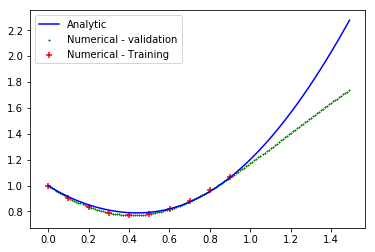

In [60]:
Xe1plot = np.arange(0,1.5, 0.01)
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0], 1, 1))
Ye1 = np.array([example1_trial_solution.predict(Xe1plot[i]) for i in range(Xe1plot.shape[0])]).reshape((Xe1plot.shape[0],))
Xe1plot = Xe1plot.reshape((Xe1plot.shape[0],))
plt.scatter(Xe1plot, Ye1, c='g', label='Numerical - validation', marker='x', s=1)
psi_e1 = lambda x:  np.exp(-0.5*x**2)/(1+x+x**3) + x**2
Ye12 = np.array([psi_e1(Xe1plot[i]) for i in range(Xe1plot.shape[0])])
plt.plot(Xe1plot, Ye12, c='b', label='Analytic')
Ye1sol = np.array([example1_trial_solution.predict(Xe1[i]) for i in range(Xe1.shape[0])]).reshape((Xe1.shape[0],))
plt.scatter(Xe1.reshape((Xe1.shape[0],)), Ye1sol, c='r', label='Numerical - Training', marker='+', s=30)
plt.legend()
plt.show()

In [61]:
Ye1_interpolation_predict = np.array([example1_trial_solution.predict(Xe1_interpolation[i]) for i in range(Xe1_interpolation.shape[0])]).reshape((Xe1_interpolation.shape[0],))
Ye1_interpolation_true = np.array([psi_e1(Xe1_interpolation[i]) for i in range(Xe1_interpolation.shape[0])]).reshape((Xe1_interpolation.shape[0],))
np.abs(Ye1_interpolation_true - Ye1_interpolation_predict).mean()

0.010700715276043205

In [62]:
np.abs(Ye1sol - np.array([psi_e1(Xe1[i]) for i in range(Xe1.shape[0])]).reshape((Xe1.shape[0],))).mean()

0.009328081327479565

In [15]:
# plt.clf()
# plt.scatter(Xe1plot, Ye1, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
# plt.scatter(Xe1.reshape((Xe1.shape[0],)), Ye1sol, c='r', label='Numerical - Training', marker='+', s=1000)
# plt.plot(Xe1plot, Ye12, c='xkcd:goldenrod', label='Analytic', linewidth=5)
# plt.xlabel(r'$x$', fontsize='50')
# plt.ylabel(r'$y$', fontsize='50')
# plt.xlim((0,1.5))
# plt.ylim((0.7,2.2))
# # plt.axis('equal')
# plt.legend(fontsize='40')
# plt.title('Example 1', fontsize='60')
# plt.gcf().set_size_inches(30, 22.5)
# plt.tick_params(axis='both', which='major', labelsize=35)
# plt.savefig('plots/example1.jpg')
# plt.show()

## Example 2

$\frac{d}{dx}\Psi+\frac{1}{5}\Psi=\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$ and domain $x\in[0,2]$

In [16]:
Xe2_interpolation = np.linspace(0,2,num=1000)
Xe2_interpolation = Xe2_interpolation.reshape((Xe2_interpolation.shape[0],1,1))
Xe2 = Xe2_interpolation[::100]
Xe2_interpolation = search(Xe2_interpolation, Xe2)
Xe2_interpolation = Xe2_interpolation.reshape((Xe2_interpolation.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x N(x)$.
The first function below is the function $A(x)=0$
and the second function is the function $B(x)=x$.

In [17]:
def example2_initial_value(point):
  return 0

In [18]:
def example2_boundary_vanishing(point):
  return point

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [19]:
def example2_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  loss = (
      point * dN + N + 0.2 * point * N - np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [20]:
def example2_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [21]:
def example2_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( point * db_DN[0, 0, m] + db_N[0, 0, m] + 0.2 * point * db_N[0, 0, m])
  return db

In [22]:
def example2_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * ( point * dH_DN[0, 0, m, p] + dH_N[0, 0, m, p] + 0.2 * point * dH_N[0, 0, m, p])
  return dH

In [23]:
def example2_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (point * dV_DN[0, 0, m, p] + dV_N[0, 0, m, p] + 0.2 * point * dV_N[0, 0, m, p])
  return dV

### Defining the trial solution with an apropiate network

In [24]:
example2_trial_solution = nnde.TrialSolution(loss_function=example2_loss_function,
                                        loss_function_single_point=example2_loss_function_single_point,
                                        bias_change=example2_bias_change,
                                        hidden_weights_change=example2_hidden_weights_change,
                                        visible_weights_change=example2_visible_weights_change,
                                        boundary_condition_value_function=example2_initial_value,
                                        boundary_vanishing_function=example2_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-1, momentum=1e-1)

### Training

In [25]:
example2_trial_solution.train(Xe2, 1000)

Epoch: 1 Loss function: 0.07711894318520318
Epoch: 2 Loss function: 0.06947673278032292
Epoch: 3 Loss function: 0.06363681671348696
Epoch: 4 Loss function: 0.0152868934335536
Epoch: 5 Loss function: 0.01605372109416061
Epoch: 6 Loss function: 0.0077074886353275555
Epoch: 7 Loss function: 0.005525136948211937
Epoch: 8 Loss function: 0.008720706876636624
Epoch: 9 Loss function: 0.008952157794498027
Epoch: 10 Loss function: 0.007379101653562137
Epoch: 11 Loss function: 0.016130078168730265
Epoch: 12 Loss function: 0.010097209114826347
Epoch: 13 Loss function: 0.010375130070333732
Epoch: 14 Loss function: 0.009446791353123369
Epoch: 15 Loss function: 0.0039251700693807975
Epoch: 16 Loss function: 0.003362335376641714
Epoch: 17 Loss function: 0.008721459450048954
Epoch: 18 Loss function: 0.004372924594292891
Epoch: 19 Loss function: 0.00514000966335267
Epoch: 20 Loss function: 0.00287369270458744
Epoch: 21 Loss function: 0.0031106048806391227
Epoch: 22 Loss function: 0.00373885003358696
Epo

Epoch: 182 Loss function: 0.00043230142851376793
Epoch: 183 Loss function: 0.0003536306878860254
Epoch: 184 Loss function: 0.0002944666586156573
Epoch: 185 Loss function: 0.0002797591571145414
Epoch: 186 Loss function: 0.00035341203092027057
Epoch: 187 Loss function: 0.0003890689531118823
Epoch: 188 Loss function: 0.0004060430541452116
Epoch: 189 Loss function: 0.0002812558522301402
Epoch: 190 Loss function: 0.00030106729716270376
Epoch: 191 Loss function: 0.00028183677567988257
Epoch: 192 Loss function: 0.00028941909741640184
Epoch: 193 Loss function: 0.0003115456506732063
Epoch: 194 Loss function: 0.0002827001609452217
Epoch: 195 Loss function: 0.00034607382872795195
Epoch: 196 Loss function: 0.00028022423571567683
Epoch: 197 Loss function: 0.00035693466894454846
Epoch: 198 Loss function: 0.0005053918532744488
Epoch: 199 Loss function: 0.00027314102840874223
Epoch: 200 Loss function: 0.00026600502668720506
Epoch: 201 Loss function: 0.0005281919858397959
Epoch: 202 Loss function: 0.00

Epoch: 358 Loss function: 0.00019718080215907073
Epoch: 359 Loss function: 0.0002256372677904333
Epoch: 360 Loss function: 0.00021228731686565684
Epoch: 361 Loss function: 0.00020605777078091633
Epoch: 362 Loss function: 0.00023005416046694942
Epoch: 363 Loss function: 0.00020645268938094397
Epoch: 364 Loss function: 0.00020581230824615707
Epoch: 365 Loss function: 0.00020962011938561808
Epoch: 366 Loss function: 0.00021701827280002725
Epoch: 367 Loss function: 0.00019565163887896655
Epoch: 368 Loss function: 0.00019549124805158047
Epoch: 369 Loss function: 0.0002175528586635433
Epoch: 370 Loss function: 0.00019944000998704613
Epoch: 371 Loss function: 0.0002000621908300952
Epoch: 372 Loss function: 0.0002019420160822515
Epoch: 373 Loss function: 0.00021377008580308887
Epoch: 374 Loss function: 0.0002329876318367205
Epoch: 375 Loss function: 0.00021652169640369465
Epoch: 376 Loss function: 0.0002046457515151845
Epoch: 377 Loss function: 0.0001944298577288811
Epoch: 378 Loss function: 0

Epoch: 538 Loss function: 0.0001789418662469586
Epoch: 539 Loss function: 0.00017834561184619337
Epoch: 540 Loss function: 0.00019320648398488816
Epoch: 541 Loss function: 0.00017942112620847857
Epoch: 542 Loss function: 0.00018274328987893593
Epoch: 543 Loss function: 0.00018186468925092148
Epoch: 544 Loss function: 0.00019310185715620796
Epoch: 545 Loss function: 0.00018556127445751153
Epoch: 546 Loss function: 0.00017978308920423423
Epoch: 547 Loss function: 0.00017753835906928782
Epoch: 548 Loss function: 0.0001807658302133225
Epoch: 549 Loss function: 0.00018274059384114455
Epoch: 550 Loss function: 0.00017773013935259855
Epoch: 551 Loss function: 0.00018001143136750183
Epoch: 552 Loss function: 0.0001788402224896963
Epoch: 553 Loss function: 0.00017835303524078074
Epoch: 554 Loss function: 0.00017773505970584182
Epoch: 555 Loss function: 0.00017758175106400781
Epoch: 556 Loss function: 0.00018162318618116007
Epoch: 557 Loss function: 0.00017896627570204346
Epoch: 558 Loss functio

Epoch: 707 Loss function: 0.0001751071081853411
Epoch: 708 Loss function: 0.00017360820063797906
Epoch: 709 Loss function: 0.00017251726207303245
Epoch: 710 Loss function: 0.00017085503450001477
Epoch: 711 Loss function: 0.00017063721051669022
Epoch: 712 Loss function: 0.00017166434302295556
Epoch: 713 Loss function: 0.00017069656431852376
Epoch: 714 Loss function: 0.00017032986492366767
Epoch: 715 Loss function: 0.0001703283485977621
Epoch: 716 Loss function: 0.0001720392650447097
Epoch: 717 Loss function: 0.00017185398381917185
Epoch: 718 Loss function: 0.00017335642601387687
Epoch: 719 Loss function: 0.00017397591814681743
Epoch: 720 Loss function: 0.00017012088154166622
Epoch: 721 Loss function: 0.00017182989195276577
Epoch: 722 Loss function: 0.00017012808877222408
Epoch: 723 Loss function: 0.00017002202822850773
Epoch: 724 Loss function: 0.0001707673798352309
Epoch: 725 Loss function: 0.00017110431200310493
Epoch: 726 Loss function: 0.00017073070778977624
Epoch: 727 Loss function

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

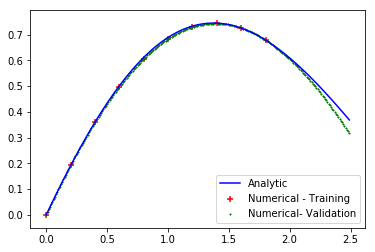

In [26]:
Ye2sol = np.array([example2_trial_solution.predict(Xe2[i]) for i in range(Xe2.shape[0])]).reshape((Xe2.shape[0],))
plt.scatter(Xe2.reshape((Xe2.shape[0],)), Ye2sol, c='r', label='Numerical - Training', marker='+', s=30)
psi_e2 = lambda x: np.exp(-0.2*x) * np.sin(x)
Xe2plot = np.arange(0,2.5, 0.01)
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0], 1, 1))
Ye2 = np.array([example2_trial_solution.predict(Xe2plot[i]) for i in range(Xe2plot.shape[0])]).reshape((Xe2plot.shape[0],))
Xe2plot = Xe2plot.reshape((Xe2plot.shape[0],))
Ye22 = np.array([np.exp(-0.2*Xe2plot[i]) * np.sin(Xe2plot[i]) for i in range(Xe2plot.shape[0])])
plt.scatter(Xe2plot, Ye2, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe2plot, Ye22, c='b', label='Analytic')
plt.legend()
plt.show()

In [27]:
Ye2_interpolation_predict = np.array([example2_trial_solution.predict(Xe2_interpolation[i]) for i in range(Xe2_interpolation.shape[0])]).reshape((Xe2_interpolation.shape[0],))
Ye2_interpolation_true = np.array([psi_e2(Xe2_interpolation[i]) for i in range(Xe2_interpolation.shape[0])]).reshape((Xe2_interpolation.shape[0],))
np.abs(Ye2_interpolation_true - Ye2_interpolation_predict).mean()

0.002632291070826591

In [28]:
np.abs(Ye2sol - np.array([psi_e2(Xe2[i]) for i in range(Xe2.shape[0])]).reshape((Xe2.shape[0],))).mean()

0.0024713965617753518

In [29]:
# plt.clf()
# plt.scatter(Xe2plot, Ye2, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
# plt.scatter(Xe2.reshape((Xe2.shape[0],)), Ye2sol, c='r', label='Numerical - Training', marker='+', s=1000)
# plt.plot(Xe2plot, Ye22, c='xkcd:goldenrod', label='Analytic', linewidth=5)
# plt.xlabel(r'$x$', fontsize='50')
# plt.ylabel(r'$y$', fontsize='50')
# plt.xlim((0,2.5))
# plt.ylim((0.,1))
# # plt.axis('equal')
# plt.legend(fontsize='40')
# plt.title('Example 2', fontsize='60')
# plt.gcf().set_size_inches(30, 22.5)
# plt.tick_params(axis='both', which='major', labelsize=35)
# plt.savefig('plots/example2.jpg')
# plt.show()

## Example 3

$\frac{d^2}{dx^2}\Psi+\frac{1}{5}\frac{d}{dx}\Psi+\Psi=-\frac{1}{5}\exp(-\frac{x}{5})\cos(x)$

With boundary initial condition $\Psi(0)=0$, $\frac{d}{dx}\Psi(0)=1$ and domain $x\in[0,2]$

Interpolation set.

In [30]:
Xe3_interpolation = np.linspace(0,2,num=1000)
Xe3_interpolation = Xe3_interpolation.reshape((Xe3_interpolation.shape[0],1,1))
Xe3 = Xe3_interpolation[::100]
Xe3_interpolation = search(Xe3_interpolation, Xe3)
Xe3_interpolation = Xe3_interpolation.reshape((Xe3_interpolation.shape[0],1,1))

The trial solution for this case is $\Psi(x)=x + x^2N(x)$.
The first function below is the function $A(x)=x$
and the second function is the function $B(x)=x^2$.

In [31]:
def example3_initial_value(point):
  return point

In [32]:
def example3_boundary_vanishing(point):
  return point ** 2

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(L\Psi(x_i, N(x_i))-f(x_i,\Psi(x_i, N(x_i))) \right)^2$$
Where N(x) is the neural network and L is some differential operator.

In [33]:
def example3_loss_function_single_point(self, point, non_squared=False, *kwargs):
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  loss = ( 2 * N + 4 * point * dN + point ** 2 * d2N + 0.2 * (1 + 2 * point * N + point ** 2 * dN)
     + point + point ** 2 * N + 0.2 * np.exp(-0.2*point)*np.cos(point)
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0,0]

In [34]:
def example3_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [35]:
def example3_bias_change(self, point, label, *kwargs):
  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
  point = point.reshape((1,))
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( 2 * db_N[0, 0, m] + 4 * point * db_DN[0, 0, m] + point ** 2 * db_D2N[0, 0, m]
                              + 0.2 * (2 * point * db_N[0, 0, m] + point ** 2 * db_DN[0, 0, m])
                              + point ** 2 * db_N[0, 0, m] 
      )
  return db

In [36]:
def example3_hidden_weights_change(self, point, *kwargs):
  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * (2 * dH_N[0, 0, m, p] + 4 * point * dH_DN[0, 0, m, p] + point ** 2 * dH_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dH_N[0, 0, m, p] + point ** 2 * dH_DN[0, 0, m, p])
                              + point ** 2 * dH_N[0, 0, m, p]
      )
  return dH

In [37]:
def example3_visible_weights_change(self, point, *kwargs):
  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * (2 * dV_N[0, 0, m, p] + 4 * point * dV_DN[0, 0, m, p] + point ** 2 * dV_D2N[0, 0, m, p]
                              + 0.2 * (2 * point * dV_N[0, 0, m, p] + point ** 2 * dV_DN[0, 0, m, p])
                              + point ** 2 * dV_N[0, 0, m, p]   
      )
  return dV

### Defining the trial solution with an apropiate network

In [38]:
example3_trial_solution = nnde.TrialSolution(loss_function=example3_loss_function,
                                        loss_function_single_point=example3_loss_function_single_point,
                                        bias_change=example3_bias_change,
                                        hidden_weights_change=example3_hidden_weights_change,
                                        visible_weights_change=example3_visible_weights_change,
                                        boundary_condition_value_function=example3_initial_value,
                                        boundary_vanishing_function=example3_boundary_vanishing,
                                        input_dim=1, hidden_dim=10, output_dim=1, learning_rate=1e-2, momentum=1e-1)

### Training

In [39]:
example3_trial_solution.train(Xe3, 1000)

Epoch: 1 Loss function: 0.23051937486405527
Epoch: 2 Loss function: 0.22200575418974208
Epoch: 3 Loss function: 0.15122389696962746
Epoch: 4 Loss function: 0.07171470963268135
Epoch: 5 Loss function: 0.11789686463832127
Epoch: 6 Loss function: 0.10146792256696827
Epoch: 7 Loss function: 0.03723261540397756
Epoch: 8 Loss function: 0.04288234758480928
Epoch: 9 Loss function: 0.02669017318522583
Epoch: 10 Loss function: 0.039521512731046225
Epoch: 11 Loss function: 0.03491342761837434
Epoch: 12 Loss function: 0.037989126158267605
Epoch: 13 Loss function: 0.04925260582618826
Epoch: 14 Loss function: 0.016167761366467824
Epoch: 15 Loss function: 0.03510943153496574
Epoch: 16 Loss function: 0.08033681603377651
Epoch: 17 Loss function: 0.0724952928760404
Epoch: 18 Loss function: 0.29788831373121294
Epoch: 19 Loss function: 0.022900318673753473
Epoch: 20 Loss function: 0.03574302787510342
Epoch: 21 Loss function: 0.012951015686146325
Epoch: 22 Loss function: 0.06632547676753395
Epoch: 23 Loss 

Epoch: 177 Loss function: 0.0002542773929940428
Epoch: 178 Loss function: 0.0003570869843735118
Epoch: 179 Loss function: 0.000458365518633384
Epoch: 180 Loss function: 0.0004862477522587856
Epoch: 181 Loss function: 0.00025419765931810674
Epoch: 182 Loss function: 0.0002485658800474587
Epoch: 183 Loss function: 0.00026275586568605657
Epoch: 184 Loss function: 0.0003302979320487274
Epoch: 185 Loss function: 0.0002499847984165133
Epoch: 186 Loss function: 0.00026710071303384647
Epoch: 187 Loss function: 0.00023525242610309918
Epoch: 188 Loss function: 0.00035288472798609917
Epoch: 189 Loss function: 0.00022210072622568915
Epoch: 190 Loss function: 0.0002300690875435587
Epoch: 191 Loss function: 0.00023253259135062724
Epoch: 192 Loss function: 0.0002207640114657449
Epoch: 193 Loss function: 0.0003054883713998868
Epoch: 194 Loss function: 0.00023273968009774183
Epoch: 195 Loss function: 0.00024702506844696554
Epoch: 196 Loss function: 0.0003709877130660947
Epoch: 197 Loss function: 0.0002

Epoch: 348 Loss function: 0.00011401568305759317
Epoch: 349 Loss function: 0.00011369964233927947
Epoch: 350 Loss function: 0.00011206255535162773
Epoch: 351 Loss function: 0.0001337761052139114
Epoch: 352 Loss function: 0.000111971593757367
Epoch: 353 Loss function: 0.00011822396479420996
Epoch: 354 Loss function: 0.0001128074508089285
Epoch: 355 Loss function: 0.00011112304452832783
Epoch: 356 Loss function: 0.00011019401293071716
Epoch: 357 Loss function: 0.00010830519934342373
Epoch: 358 Loss function: 0.00010832241748163896
Epoch: 359 Loss function: 0.00010802156275830772
Epoch: 360 Loss function: 0.00011232332799219268
Epoch: 361 Loss function: 0.00011450491803487455
Epoch: 362 Loss function: 0.00013420693247874897
Epoch: 363 Loss function: 0.0001122993914641491
Epoch: 364 Loss function: 0.00011265672516722752
Epoch: 365 Loss function: 0.00011416561445387686
Epoch: 366 Loss function: 0.000108681607229981
Epoch: 367 Loss function: 0.00010701709651773992
Epoch: 368 Loss function: 0

Epoch: 520 Loss function: 9.824796423478171e-05
Epoch: 521 Loss function: 9.710266086179807e-05
Epoch: 522 Loss function: 0.00010057471812705697
Epoch: 523 Loss function: 9.677075989843755e-05
Epoch: 524 Loss function: 9.626060862496857e-05
Epoch: 525 Loss function: 9.649752712242096e-05
Epoch: 526 Loss function: 9.665249268517545e-05
Epoch: 527 Loss function: 9.674563407208574e-05
Epoch: 528 Loss function: 9.614595242294345e-05
Epoch: 529 Loss function: 9.674612518110578e-05
Epoch: 530 Loss function: 0.00010059382905272938
Epoch: 531 Loss function: 9.635690076069967e-05
Epoch: 532 Loss function: 9.879337913495337e-05
Epoch: 533 Loss function: 9.670414841033967e-05
Epoch: 534 Loss function: 0.00010403706215250511
Epoch: 535 Loss function: 0.00010202333510024231
Epoch: 536 Loss function: 9.687744986768526e-05
Epoch: 537 Loss function: 9.589214271551413e-05
Epoch: 538 Loss function: 9.821704253483313e-05
Epoch: 539 Loss function: 0.0001012325599028956
Epoch: 540 Loss function: 0.00010724

Epoch: 701 Loss function: 9.328498138748816e-05
Epoch: 702 Loss function: 9.332629002233528e-05
Epoch: 703 Loss function: 9.28724167284191e-05
Epoch: 704 Loss function: 9.246455400855557e-05
Epoch: 705 Loss function: 0.00010572144804813445
Epoch: 706 Loss function: 9.242445609418275e-05
Epoch: 707 Loss function: 9.839550244215031e-05
Epoch: 708 Loss function: 9.485562306238607e-05
Epoch: 709 Loss function: 9.313436964730256e-05
Epoch: 710 Loss function: 9.799629973451869e-05
Epoch: 711 Loss function: 9.40493041218644e-05
Epoch: 712 Loss function: 9.85066391861487e-05
Epoch: 713 Loss function: 9.357333939935868e-05
Epoch: 714 Loss function: 9.30145404492473e-05
Epoch: 715 Loss function: 9.33431848745536e-05
Epoch: 716 Loss function: 9.273277888424868e-05
Epoch: 717 Loss function: 9.252083693517745e-05
Epoch: 718 Loss function: 0.00010038357633635584
Epoch: 719 Loss function: 9.439539842853899e-05
Epoch: 720 Loss function: 9.325780691477219e-05
Epoch: 721 Loss function: 9.382930625583975

Epoch: 900 Loss function: 9.110606114123662e-05
Epoch: 901 Loss function: 9.105171197455427e-05
Epoch: 902 Loss function: 9.173192257585282e-05
Epoch: 903 Loss function: 9.056216965700766e-05
Epoch: 904 Loss function: 9.055318120867312e-05
Epoch: 905 Loss function: 9.155724131982266e-05
Epoch: 906 Loss function: 9.362018855147486e-05
Epoch: 907 Loss function: 9.039602779988608e-05
Epoch: 908 Loss function: 9.125765167077448e-05
Epoch: 909 Loss function: 9.162153104657842e-05
Epoch: 910 Loss function: 9.36588833720801e-05
Epoch: 911 Loss function: 9.130501115816286e-05
Epoch: 912 Loss function: 9.156795466947145e-05
Epoch: 913 Loss function: 9.11737261618717e-05
Epoch: 914 Loss function: 9.328402490331847e-05
Epoch: 915 Loss function: 9.407345921623563e-05
Epoch: 916 Loss function: 9.035617293424029e-05
Epoch: 917 Loss function: 9.036978700197542e-05
Epoch: 918 Loss function: 9.162024969730304e-05
Epoch: 919 Loss function: 9.035419053016152e-05
Epoch: 920 Loss function: 9.31648239420863

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

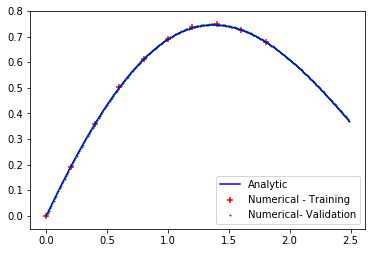

In [40]:
Ye3sol = np.array([example3_trial_solution.predict(Xe3[i]) for i in range(Xe3.shape[0])]).reshape((Xe3.shape[0],))
plt.scatter(Xe3.reshape((Xe3.shape[0],)), Ye3sol, c='r', label='Numerical - Training', marker='+', s=30)
Xe3plot = np.arange(0,2.5, 0.01)
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0], 1, 1))
Ye3 = np.array([example3_trial_solution.predict(Xe3plot[i]) for i in range(Xe3plot.shape[0])]).reshape((Xe3plot.shape[0],))
Xe3plot = Xe3plot.reshape((Xe3plot.shape[0],))
psi_e3 = lambda x: np.exp(-0.2*x) * np.sin(x)
Ye33 = np.array([psi_e3(Xe3plot[i]) for i in range(Xe3plot.shape[0])])
plt.scatter(Xe3plot, Ye3, c='g', label='Numerical- Validation', marker='x', s=1)
plt.plot(Xe3plot, Ye33, c='b', label='Analytic')
plt.legend()
plt.show()

In [41]:
print(example3_trial_solution.network.hidden_layer.bias.min())
print(example3_trial_solution.network.hidden_layer.bias.max())
print(example3_trial_solution.network.hidden_layer.weights.min())
print(example3_trial_solution.network.hidden_layer.weights.max())
print(example3_trial_solution.network.visible_layer.weights.min())
print(example3_trial_solution.network.visible_layer.weights.max())

-0.21115618351148063
0.1559358134045624
-0.6655182624067064
0.9251371036459658
-0.7770699443095329
0.8368509257535816


In [42]:
Ye3_interpolation_predict = np.array([example3_trial_solution.predict(Xe3_interpolation[i]) for i in range(Xe3_interpolation.shape[0])]).reshape((Xe3_interpolation.shape[0],))
Ye3_interpolation_true = np.array([psi_e3(Xe3_interpolation[i]) for i in range(Xe3_interpolation.shape[0])]).reshape((Xe3_interpolation.shape[0],))
np.abs(Ye3_interpolation_true - Ye3_interpolation_predict).mean()

0.0012983649228429628

In [43]:
np.abs(Ye3sol - np.array([psi_e3(Xe3[i]) for i in range(Xe3.shape[0])]).reshape((Xe3.shape[0],))).mean()

0.0012627930167426916

In [44]:
# plt.clf()
# plt.scatter(Xe3plot, Ye3, c='xkcd:sky blue', label='Numerical - validation', marker='x', s=300)
# plt.scatter(Xe3.reshape((Xe3.shape[0],)), Ye3sol, c='r', label='Numerical - Training', marker='+', s=1000)
# plt.plot(Xe3plot, Ye33, c='xkcd:goldenrod', label='Analytic', linewidth=5)
# plt.xlabel(r'$x$', fontsize='50')
# plt.ylabel(r'$y$', fontsize='50')
# plt.xlim((0,2.5))
# plt.ylim((0.,0.8))
# # plt.axis('equal')
# plt.legend(fontsize='40')
# plt.title('Example 3', fontsize='60')
# plt.gcf().set_size_inches(30, 22.5)
# plt.tick_params(axis='both', which='major', labelsize=35)
# plt.savefig('plots/example3.jpg')
# plt.show()